In [1]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import IPython.display as ipd
import numpy as np
%matplotlib notebook

# Phasor

#### sounding rate -  1초에 숫자가 몇개인지, 몇개를 받아올지
    frequency - 1초에 sin이 몇개 반복 되는지, 소리의 높낮이를 결정
    time series

In [20]:
# parameter setting
amp = 1     # range [0.0, 1.0]
sr = 10000       # sampling rate, Hz, must be integer 
dur = 1   # in seconds, may be float
freq = 100.0        # sine frequency, Hz, may be float

#### 모든 sound는 sin wave들의 합이다
    sin wave는 1초에 백번 왔다갔다 한다 하면 100Hz라고 표현,  얼마나 단위 시간 동안 왔다갔다 하는가 -  소리의 높낮이 결정
    sin wave를 통해 진폭(amplitude)도 알 수 있다 - 음의 강도결정
    

#### 시간이라는 범위를 항상 먼저 정해줘야 어떤 것을 만들어 재생할 수 있다

#### 1/10000부터 5000/10000 까지 

#### sr을 10000으로 정의했으므로 1부터 9999까지 일단 설정
    np.arrange(1,sr+1)/sr은 1/10000부터 1초 사이까지
    np.arrange(1, sr*0.5+1)1/10000q부터 5000/10000까지 
    np. arrange(1, sr*0.5)라고 하면 1부터 4999까지임


In [21]:
# generate time
t = np.arange(1, sr * dur+1)/sr 

#### t*2*np.pi가 초를 하나의 frequency를 이루는 radian으로 변환하는 과정

In [22]:
# generate phase
theta = t * 2*np.pi * freq   

#### theta 값으로 input은 각도를 받아온다
    theta, s의 크기는 계속 10000

In [23]:
# generate signal by cosine-phasor
s = amp*np.sin(theta)

#### sr을 바꿔도 200까지 보여주라고 했으니까
sr=10000이면 시간이 더 짧고 sr=5000이면 더 길어짐
time은 x축, sin값이 y축

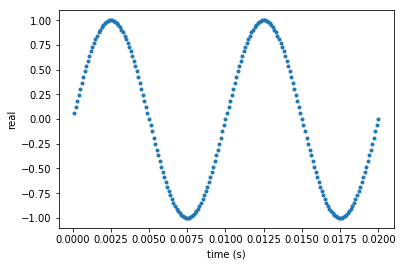

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:200], s[0:200], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('real')
ipd.Audio(s, rate=sr)

#### e의 θi 승(i는 파이썬에서 j로 표현)
    복소수는 실수도 포함한다
    sin을 e의 i승으로 바꾸어 삼차원으로 표현, sin의 θ승 그래프를 삼차원으로 표현
    sin θi승 대신 exponential θi로 바꿔주는 식

In [25]:
# generate signal by exponential-phasor
c = amp*np.exp(theta*1j)

#### plot(a+bi)
    c.real - a부분
    c.imag - b부분

#### exponential 의 θi승을 plot해서 허수 측면에서 보면 sin 그래프가 나오더라

Text(0.5,0,'imag')

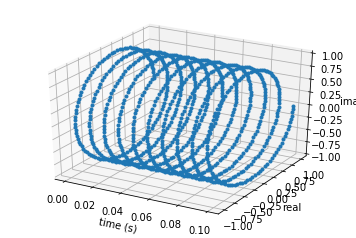

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(t[0:1000], c.real[0:1000], c.imag[0:1000], '.')
ax.set_xlabel('time (s)')
ax.set_ylabel('real')
ax.set_zlabel('imag')

In [18]:
ipd.Audio(s, rate=sr)

# Generate pulse train

# sin wave들을 합쳐 하나의 소리를 만드는 함수만들기
    기본값을 설정해 F0이라고 이름 붙이고, sr의 범위를 지정한다
    계속 sin wave들을 더해나갈 기본 틀을 s로 만든다
    tmp에서 radian으로 바뀐 frequency를 받아 진폭을 설정해 이 sin wave들을 다 합한다

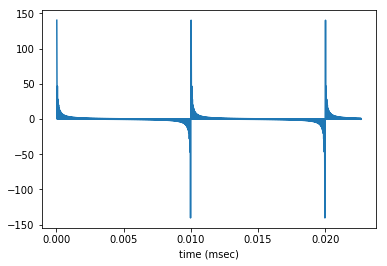

In [11]:
# generate samples, note conversion to float32 array
F0 = 100; Fend = int(sr/2); s = np.zeros(len(t));
for freq in range(F0, Fend, F0):
    theta = t * 2*np.pi * freq
    tmp = amp * np.sin(theta)
    s = s + tmp
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(t[0:1000], s[0:1000]); 
ax.set_xlabel('time (msec)')
ipd.Audio(s, rate=sr)

# load wav

In [24]:
from scipy.io import wavfile
sr, s = wavfile.read('a.wav')
nSamp = len(s)
dur = nSamp / sr
t = np.linspace(1/sr, dur, nSamp)

# fourier tranform

In [25]:
nFFT = 512
amp = [];
for n in range(1,nFFT+1):
    theta = 2*np.pi*n/nFFT * np.arange(1,nSamp+1)
    c = np.exp(theta*1j)
    amp.append(np.abs(np.dot(s,c)))

Text(0, 0.5, 'amplitude')

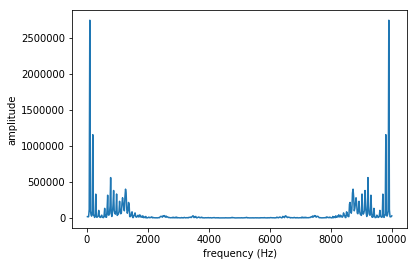

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111)
freq = np.arange(1,nFFT+1)*sr/nFFT;
ax.plot(freq, amp)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('amplitude')

# define spectrogram functions

In [ ]:
def gaussian_spectrogram(x, fs, window_dur=0.005, step_dur=None, dyn_range=120, 
                         cmap=None, ax=None):
    from scipy.signal import spectrogram, gaussian
    from matplotlib.colors import LogNorm
    from matplotlib.cm import get_cmap
    
    # set default for step_dur, if unspecified. This value is optimal for Gaussian windows.
    if step_dur is None:
        step_dur = window_dur / np.sqrt(np.pi) / 8
    
    # convert window & step durations from seconds to numbers of samples (which is what
    # scipy.signal.spectrogram takes as input).
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    
    # make the window. A Gaussian filter needs a minimum of 6σ - 1 samples, so working
    # backward from window_nsamp we can calculate σ.
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    
    # convert step size into number of overlapping samples in adjacent analysis frames
    noverlap = window_nsamp - step_nsamp
    
    # compute the power spectral density
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)

    p_ref = 2e-5  # 20 μPa, the standard reference pressure for sound in air

    # set lower bound of colormap (vmin) from dynamic range. The upper bound defaults
    # to the largest value in the spectrogram, so we don't need to set it explicitly.
    dB_max = 10 * np.log10(power.max() / (p_ref ** 2))
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)

    # set default colormap, if none specified
    if cmap is None:
        cmap = get_cmap('Greys')
    # or if cmap is a string, get the actual object
    elif isinstance(cmap, str):
        cmap = get_cmap(cmap)

    # create the figure if needed
    if ax is None:
        fig, ax = plt.subplots()

    # other arguments to the figure
    extent = (times.min(), times.max(), freqs.min(), freqs.max())

    # plot
    ax.imshow(power, origin='lower', aspect='auto', cmap=cmap,
              norm=LogNorm(), extent=extent, vmin=vmin, vmax=None)
    return ax

def praat_spectrogram(x, fs, window_dur=0.005, dyn_range=120, ax=None):
    # this function is less flexible than the other (to make it shorter, 
    # since it's just for demo purposes).
    from scipy.signal import spectrogram, gaussian
    from matplotlib.cm import get_cmap
    
    step_dur = window_dur / np.sqrt(np.pi) / 8.
    window_nsamp = int(window_dur * fs * 2)
    step_nsamp = int(step_dur * fs)
    window_sigma = (window_nsamp + 1) / 6
    window = gaussian(window_nsamp, window_sigma)
    noverlap = window_nsamp - step_nsamp
    freqs, times, power = spectrogram(x, detrend=False, mode='psd', fs=fs,
                                      scaling='density', noverlap=noverlap,
                                      window=window, nperseg=window_nsamp)
    p_ref = 2e-5
    log_psd = 10 * np.log10(power / (p_ref ** 2))  # key difference
    dB_max = log_psd.max()
    vmin = p_ref * 10 ** ((dB_max - dyn_range) / 10)
    cmap = get_cmap('Greys')
    if ax is None:
        fig, ax = plt.subplots()
    extent = (times.min(), times.max(), freqs.min(), freqs.max())
    # next line: pass `log_psd` instead of `power`; no `LogNorm`
    ax.imshow(log_psd, origin='lower', aspect='auto', cmap=cmap,
              extent=extent, vmin=vmin, vmax=None)
    return ax

# display spectrogram

Text(0.5, 1.0, 'Log power spectral density & linear colormap')

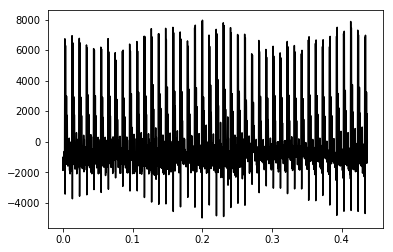

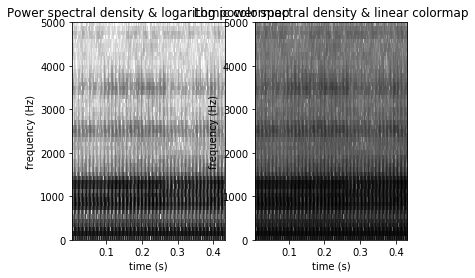

In [6]:
plt.plot(t,s, 'k')

fig, axs = plt.subplots(1, 2)
ax = gaussian_spectrogram(s, sr, ax=axs[0])
ax.set_ylim(0, sr/2)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Power spectral density & logarithmic colormap')

ax = praat_spectrogram(s, sr, ax=axs[1])
ax.set_ylim(0, sr/2)
ax.set_xlabel('time (s)')
ax.set_ylabel('frequency (Hz)')
ax.set_title('Log power spectral density & linear colormap')